## TODO:

- count of climate related words in posts [sustain*, energy, carbon, emission, energy, consumption etc]
- avg vad, sm, concrete of subreddits
- avg vad etc of each cluster
- add more posts and comments??
- other subreddits?
- subreddits on climate?
- AI policy docs per sentence analysis
- count of climate related words in AI policy docs, word2vec see most related words to these 
- vs sustainability policy docs 

- permutation test to see if difference in vad etc between different subreddits/sources/topics are statistically significant (? dont kill me MB)

In [5]:
import json 
import pandas as pd
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.data
from nltk.tokenize import regexp_tokenize
from nltk import pos_tag
import string
import pdfplumber
import re
import numpy as np
import praw
import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import umap.umap_ as UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance

# show nltk's list of stopwords
# Loading PunktSentenceTokenizer using English pickle file
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
stops = stopwords.words('english')
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Coffee Addict\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Coffee
[nltk_data]     Addict\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Coffee
[nltk_data]     Addict\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


OSError: No such file or directory: 'C:\\Users\\Coffee Addict\\AppData\\Roaming\\nltk_data\\tokenizers\\punkt\\PY3\\PY3\\english.pickle'

In [17]:
lemmatizer = WordNetLemmatizer()

In [5]:
def pdf_to_text(pdf_path, output_txt):

    with pdfplumber.open(pdf_path) as pdf: 
        # pdf_reader = PyPDF2.PdfReader(pdf_file)
        text = ''
        for page in pdf.pages:
            text += page.extract_text().replace("\n", " ")
            
            

        # for page_num in range(len(pdf_reader.pages)):
        #     page = pdf_reader.pages[page_num]
        #     text += page.extract_text() 
            

        # with open(output_txt, 'w', encoding='utf-8') as txt_file:
        #     txt_file.write(text) 

        return text 

In [4]:
data = pd.DataFrame([], columns=["title", "text"])
pdfs = ["accelerating-climate-action-ai-google.pdf", "google-2023-environmental-report.pdf", "National_AI_Strategy_-_PDF_version.pdf", "UNESCO-AI-Ethics.pdf", "national_ai_rd_strategic_plan.pdf"] 
texts = ["climate-action-google.txt","google-environ-report.txt", "uk-national-strategy.txt", "unesco-ai-ethics.txt", "national_ai_rd_strategic_plan.txt"]

for i in range(len(pdfs)):
    data.loc[-1] = [texts[i], pdf_to_text(f'dataset/{pdfs[i]}', f'dataset/{texts[i]}')]
    # data.loc[-1] = [texts[i], textract.process(f'dataset/{pdfs[0]}', method="pdfminer").decode("utf8")]
    data.index = data.index + 1
    data = data.sort_index()

In [5]:
data["text"]

0    THE NATIONAL ARTIFICIAL INTELLIGENCE RESEARCH ...
1    Recommendation on the Ethics of Artificial Int...
2    National AI StrategyNational AI Strategy Prese...
3    Environmental Report 20232023 Environmental Re...
4    Accelerating Climate Action with AI November 2...
Name: text, dtype: object

In [6]:
data["sentences"] = data["text"].apply(tokenizer.tokenize)

In [7]:
data["cleaned"] = data["text"].str.lower()
data['cleaned'] = data['cleaned'].apply(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", x))
data["cleaned"] = data["cleaned"].str.split()
data["cleaned"] = data["cleaned"].apply(lambda x: [w for w in x if w not in stops])


In [8]:
def clean_sent(X): 
    lowered = []
    for i in X: 
        clean = i.lower()
        clean = clean.translate(str.maketrans('', '', string.punctuation))
        clean = ' '.join([w for w in clean.split() if w not in stops])
        lowered.append(clean) 
    return lowered

In [9]:
data["clean sent"] = data["sentences"].apply(clean_sent)

In [16]:
def lemma(row):
    row_ = []
    for i in row: 
        sent = " ".join([lemmatizer.lemmatize(word) for word in i.split()])
        row_.append(sent)
    return row_
        
data["clean sent"] = data["clean sent"].apply(lemma)


NameError: name 'data' is not defined

In [11]:
lemmatizer.lemmatize("dogs")

'dog'

In [12]:
data.head()

,title,text,sentences,cleaned,clean sent
0,national_ai_rd_strategic_plan.txt,THE NATIONAL ARTIFICIAL INTELLIGENCE RESEARCH ...,[THE NATIONAL ARTIFICIAL INTELLIGENCE RESEARCH...,"[national, artificial, intelligence, research,...",[national artificial intelligence research dev...
1,unesco-ai-ethics.txt,Recommendation on the Ethics of Artificial Int...,[Recommendation on the Ethics of Artificial In...,"[recommendation, ethics, artificial, intellige...",[recommendation ethic artificial intelligence ...
2,uk-national-strategy.txt,National AI StrategyNational AI Strategy Prese...,[National AI StrategyNational AI Strategy Pres...,"[national, ai, strategynational, ai, strategy,...",[national ai strategynational ai strategy pres...
3,google-environ-report.txt,Environmental Report 20232023 Environmental Re...,[Environmental Report 20232023 Environmental R...,"[environmental, report, 20232023, environmenta...",[environmental report 20232023 environmental r...
4,climate-action-google.txt,Accelerating Climate Action with AI November 2...,[Accelerating Climate Action with AI November ...,"[accelerating, climate, action, ai, november, ...",[accelerating climate action ai november 2023 ...


In [22]:
# create dataframe from "VAD_lexicon.txt" file of english words with VAD values 
vad = pd.read_excel("vad.xlsx").set_index("word")

# create dataframe from "conreteness.xlsx" file of englsih words with concreteness values 
concrete = pd.read_excel("concreteness.xlsx")
# remove the Bigram rows from the file - we focus only on single words 
concrete = concrete[concrete["Bigram"] == 0] 
# remove all other columns except mean concreteness (Conc.M)
concrete = concrete[['Word','Conc.M']].set_index("Word") 

sensory = pd.read_excel("sensorimotor.xlsx").set_index("word")

In [14]:
def calc_values(row):

    # create list of words from the clean tweet of the given row that are also in the vad lexicon
    vad_words = [i for i in row.loc["cleaned"] if i in vad.index]
    # create another list but for words in the concreteness lexicon
    concrete_words = [i for i in row.loc["cleaned"] if i in concrete.index]
    sensory_words = [i for i in row.loc["cleaned"] if i in sensory.index]


    # calculate the mean VAD scores of from the list of vad_words
    avg_aro = np.array([vad.loc[i]['arousal'] for i in vad_words]).mean()
    avg_val = np.array([vad.loc[i]['valence'] for i in vad_words]).mean()
    avg_dom = np.array([vad.loc[i]['dominance'] for i in vad_words]).mean()

    # calcualte the mean concreteness 
    avg_con = np.array([concrete.loc[i]['Conc.M'] for i in concrete_words]).mean()

    # calculate the mean sensorimotor scores of from the list of sensory 
    avg_aud = np.array([sensory.loc[i]['auditory'] for i in sensory_words]).mean()
    avg_gust = np.array([sensory.loc[i]['gustatory'] for i in sensory_words]).mean()
    avg_hap = np.array([sensory.loc[i]['haptic'] for i in sensory_words]).mean()
    avg_intero = np.array([sensory.loc[i]['interoceptive'] for i in sensory_words]).mean()
    avg_olf = np.array([sensory.loc[i]['olfactory'] for i in sensory_words]).mean()
    avg_vis = np.array([sensory.loc[i]['visual'] for i in sensory_words]).mean()
    avg_foot = np.array([sensory.loc[i]['foot_leg'] for i in sensory_words]).mean()
    avg_hand = np.array([sensory.loc[i]['hand_arm'] for i in sensory_words]).mean()
    avg_head = np.array([sensory.loc[i]['head'] for i in sensory_words]).mean()
    avg_mouth = np.array([sensory.loc[i]['mouth'] for i in sensory_words]).mean()
    avg_torso = np.array([sensory.loc[i]['torso'] for i in sensory_words]).mean()
    avg_known = np.array([sensory.loc[i]['percent_known'] for i in sensory_words]).mean()
    
    return avg_val, avg_aro, avg_dom, avg_con, avg_aud, avg_gust, avg_hap, avg_intero, avg_olf, avg_vis, avg_foot, avg_hand, avg_head, avg_mouth, avg_torso, avg_known

In [15]:
data[['valence', 'arousal', 'dominance', 'concreteness', "aud","gust","hap","intero","olf", "vis", "foot","hand", "head", "mouth", "torso", "percent known"]]= data.apply(calc_values, axis=1, result_type="expand")
data.head()

,title,text,sentences,cleaned,clean sent,valence,arousal,dominance,concreteness,aud,...,hap,intero,olf,vis,foot,hand,head,mouth,torso,percent known
0,national_ai_rd_strategic_plan.txt,THE NATIONAL ARTIFICIAL INTELLIGENCE RESEARCH ...,[THE NATIONAL ARTIFICIAL INTELLIGENCE RESEARCH...,"[national, artificial, intelligence, research,...",[national artificial intelligence research dev...,0.626783,0.523210,0.621890,2.778192,1.866619,...,1.034938,1.145487,0.413844,3.015569,0.975896,1.585521,2.727271,1.457880,0.898471,0.987900
1,unesco-ai-ethics.txt,Recommendation on the Ethics of Artificial Int...,[Recommendation on the Ethics of Artificial In...,"[recommendation, ethics, artificial, intellige...",[recommendation ethic artificial intelligence ...,0.630101,0.520864,0.612644,2.620883,1.903128,...,0.906187,1.255466,0.419205,2.854318,1.018842,1.515082,2.682255,1.600314,0.977533,0.986842
2,uk-national-strategy.txt,National AI StrategyNational AI Strategy Prese...,[National AI StrategyNational AI Strategy Pres...,"[national, ai, strategynational, ai, strategy,...",[national ai strategynational ai strategy pres...,0.622226,0.516430,0.618234,2.793435,1.815871,...,0.925700,1.085501,0.380945,2.951213,1.013791,1.508572,2.621051,1.481536,0.937407,0.983979
3,google-environ-report.txt,Environmental Report 20232023 Environmental Re...,[Environmental Report 20232023 Environmental R...,"[environmental, report, 20232023, environmenta...",[environmental report 20232023 environmental r...,0.627520,0.525192,0.593528,3.098558,1.534489,...,1.177050,1.045766,0.507023,3.131662,1.114976,1.735047,2.528409,1.340616,0.995367,0.988622
4,climate-action-google.txt,Accelerating Climate Action with AI November 2...,[Accelerating Climate Action with AI November ...,"[accelerating, climate, action, ai, november, ...",[accelerating climate action ai november 2023 ...,0.610943,0.529107,0.588197,2.953335,1.648911,...,1.076496,1.142373,0.425946,3.052590,1.101668,1.691206,2.601070,1.406426,0.999955,0.988012


In [16]:
fd = nltk.FreqDist(data["cleaned"][0])

In [17]:
fd.most_common(10)

[('ai', 472),
 ('systems', 208),
 ('research', 188),
 ('r', 107),
 ('data', 100),
 ('plan', 96),
 ('technology', 95),
 ('intelligence', 91),
 ('strategic', 89),
 ('artificial', 87)]

In [18]:
fd1 = nltk.FreqDist(data["cleaned"][1])
fd1.most_common(10)

[('ai', 346),
 ('systems', 152),
 ('states', 137),
 ('member', 134),
 ('human', 129),
 ('data', 88),
 ('including', 88),
 ('rights', 85),
 ('ethical', 73),
 ('international', 71)]

In [19]:
fd2 = nltk.FreqDist(data["cleaned"][2])
fd2.most_common(10)


[('ai', 103),
 ('strategy', 43),
 ('national', 30),
 ('uk', 27),
 ('1', 22),
 ('2', 20),
 ('ecosystem', 18),
 ('3', 17),
 ('term', 14),
 ('innovation', 14)]

In [20]:
fd3 = nltk.FreqDist(data["cleaned"][3])
fd3.most_common(10)

[('energy', 467),
 ('google', 432),
 ('data', 414),
 ('emissions', 370),
 ('water', 330),
 ('2022', 327),
 ('carbon', 324),
 ('1', 263),
 ('climate', 255),
 ('environmental', 251)]

### Subreddit Posts

In [8]:
reddit = praw.Reddit(user_agent='VAD',
                    client_id='3CzRz9K7KxTXz_oTGCucgw', client_secret= "ziOA17ICUCb2nKPX0XFLOVtFC5FwjQ",
                    username= 'ProperSkill2215', password= '64-ttnegb3TzVdN')

In [9]:
def subreddit_posts(subred_name):

    subreddit = reddit.subreddit(subred_name)
    post_comments = [] 
    submissions = subreddit.top(limit=1000)
    for submission in submissions:
        post = {
            'text': submission.selftext,
            'datetime': datetime.datetime.fromtimestamp(submission.created_utc),
            'score': submission.score,
            'subeddit': submission.subreddit,
            'type': 'submisison',
            'title': submission.title
        }
        post_comments.append(post)

        # submission.comments.replace_more()
        # for comment in submission.comments.list():
        #     comment = {
        #         'text': comment.body,
        #         'datetime': datetime.datetime.fromtimestamp(comment.created_utc),
        #         'score': comment.score,
        #         'subreddit': submission.subreddit,
        #         'type': 'comment',
        #         'title': submission.title
        #     }
        #     post_comments.append(comment)

    
    return pd.DataFrame.from_dict(post_comments)

In [10]:
chat = subreddit_posts("ChatGPT")
claude = subreddit_posts("ClaudeAI")
gemini = subreddit_posts("Bard")

In [11]:
posts = pd.concat([chat, claude, gemini]).reset_index(drop=True)

In [12]:
len(posts)

2976

In [100]:
def clean_text(row, join=False): 
    clean = row.lower()
    clean = clean.translate(str.maketrans('', '', string.punctuation))
    clean = [w for w in clean.split() if w not in stops]
    if join:
        clean = " ".join(clean)
    return clean

In [18]:
posts["clean title"] = posts["title"].apply(clean_text)
posts["clean title"] = posts["clean title"].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [19]:
posts

,text,datetime,score,subeddit,type,title,clean title
0,,2023-06-08 21:16:59,67098,ChatGPT,submisison,Turned ChatGPT into the ultimate bro,"[turned, chatgpt, ultimate, bro]"
1,,2024-02-19 22:37:20,55734,ChatGPT,submisison,Will smith is wild for this,"[smith, wild]"
2,,2023-05-31 07:25:04,51892,ChatGPT,submisison,Photoshop AI Generative Fill was used for its ...,"[photoshop, ai, generative, fill, used, intend..."
3,The guy typing out these responses for Bing mu...,2023-06-23 03:41:46,51116,ChatGPT,submisison,"Bing ChatGPT too proud to admit mistake, doubl...","[bing, chatgpt, proud, admit, mistake, double,..."
4,,2023-04-05 15:39:56,44259,ChatGPT,submisison,Was curious if GPT-4 could recognize text art,"[curious, gpt4, could, recognize, text, art]"
...,...,...,...,...,...,...,...
2971,"Hi there,\n\nI have made a video [here](https:...",2023-05-01 09:31:12,19,Bard,submisison,Why Language Models Hallucinate,"[language, model, hallucinate]"
2972,,2023-04-26 21:39:14,19,Bard,submisison,Dear Bard,"[dear, bard]"
2973,,2023-04-26 00:29:48,19,Bard,submisison,Bard fantasizes about running away to the wood...,"[bard, fantasizes, running, away, wood]"
2974,It's seems you're available worldwide\n\n\nTha...,2023-04-21 15:01:32,18,Bard,submisison,It's seems Bard is available in some country w...,"[seems, bard, available, country, without, vpn]"


In [20]:
def calc_values(row, col):

    # create list of words from the clean tweet of the given row that are also in the vad lexicon
    vad_words = [i for i in row.loc[col] if i in vad.index]
    # create another list but for words in the concreteness lexicon
    concrete_words = [i for i in row.loc[col] if i in concrete.index]
    sensory_words = [i for i in row.loc[col] if i in sensory.index]


    # calculate the mean VAD scores of from the list of vad_words
    avg_aro = np.array([vad.loc[i]['arousal'] for i in vad_words]).mean()
    avg_val = np.array([vad.loc[i]['valence'] for i in vad_words]).mean()
    avg_dom = np.array([vad.loc[i]['dominance'] for i in vad_words]).mean()

    # calcualte the mean concreteness 
    avg_con = np.array([concrete.loc[i]['Conc.M'] for i in concrete_words]).mean()

    # calculate the mean sensorimotor scores of from the list of sensory 
    avg_aud = np.array([sensory.loc[i]['auditory'] for i in sensory_words]).mean()
    avg_gust = np.array([sensory.loc[i]['gustatory'] for i in sensory_words]).mean()
    avg_hap = np.array([sensory.loc[i]['haptic'] for i in sensory_words]).mean()
    avg_intero = np.array([sensory.loc[i]['interoceptive'] for i in sensory_words]).mean()
    avg_olf = np.array([sensory.loc[i]['olfactory'] for i in sensory_words]).mean()
    avg_vis = np.array([sensory.loc[i]['visual'] for i in sensory_words]).mean()
    avg_foot = np.array([sensory.loc[i]['foot_leg'] for i in sensory_words]).mean()
    avg_hand = np.array([sensory.loc[i]['hand_arm'] for i in sensory_words]).mean()
    avg_head = np.array([sensory.loc[i]['head'] for i in sensory_words]).mean()
    avg_mouth = np.array([sensory.loc[i]['mouth'] for i in sensory_words]).mean()
    avg_torso = np.array([sensory.loc[i]['torso'] for i in sensory_words]).mean()
    avg_known = np.array([sensory.loc[i]['percent_known'] for i in sensory_words]).mean()
    
    return avg_val, avg_aro, avg_dom, avg_con, avg_aud, avg_gust, avg_hap, avg_intero, avg_olf, avg_vis, avg_foot, avg_hand, avg_head, avg_mouth, avg_torso, avg_known

In [23]:
posts[['valence', 'arousal', 'dominance', 'concreteness', "aud","gust","hap","intero","olf", "vis", "foot","hand", "head", "mouth", "torso", "percent known"]]= posts.apply(calc_values, args=("clean title",), axis=1, result_type="expand")

/tmp/ipykernel_81/4144164590.py:11: RuntimeWarning: Mean of empty slice.
  avg_aro = np.array([vad.loc[i]['arousal'] for i in vad_words]).mean()
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_81/4144164590.py:12: RuntimeWarning: Mean of empty slice.
  avg_val = np.array([vad.loc[i]['valence'] for i in vad_words]).mean()
/tmp/ipykernel_81/4144164590.py:13: RuntimeWarning: Mean of empty slice.
  avg_dom = np.array([vad.loc[i]['dominance'] for i in vad_words]).mean()
/tmp/ipykernel_81/4144164590.py:16: RuntimeWarning: Mean of empty slice.
  avg_con = np.array([concrete.loc[i]['Conc.M'] for i in concrete_words]).mean()
/tmp/ipykernel_81/4144164590.py:19: RuntimeWarning: Mean of empty slice.
  avg_aud = np.array([sensory.loc[i]['auditory'] for i in sensory_words]).mean()
/tmp/ipykernel_81/4144164590.py:20: RuntimeWarning: Mean of empty slice.
  avg_gust = np.ar

In [25]:
posts["clean title"] = posts["clean title"].apply(' '.join)

In [69]:
posts[posts['clean title'].str.contains('impact')]

,text,datetime,score,subeddit,type,title,clean title,valence,arousal,dominance,...,intero,olf,vis,foot,hand,head,mouth,torso,percent known,Topic
750,"I am an engineer in a non-IT field, and in my ...",2023-04-02 11:13:59,3647,ChatGPT,submisison,"The Real World Impact of GPT4. Strap in, it's ...",real world impact gpt4 strap sure bumpy ride,0.666757,0.615780,0.621663,...,1.924100,1.044813,3.351637,1.972673,2.592938,2.521120,1.522874,1.930523,0.989846,0
897,The news that Chegg stock dropped nearly 50% i...,2023-05-04 00:25:25,3084,ChatGPT,submisison,Chegg's stock falls 50% due to ChatGPT's impac...,cheggs stock fall 50 due chatgpts impact even ...,0.469765,0.630176,0.488384,...,1.203352,0.347364,3.182466,1.209273,1.823941,2.534706,1.071214,1.231143,0.992839,-1


In [63]:
posts[posts["text"] == ""]

,text,datetime,score,subeddit,type,title,clean title,valence,arousal,dominance,...,intero,olf,vis,foot,hand,head,mouth,torso,percent known,Topic
0,,2023-06-08 21:16:59,67098,ChatGPT,submisison,Turned ChatGPT into the ultimate bro,turned chatgpt ultimate bro,0.700935,0.761578,0.495146,...,1.084378,0.441103,2.538847,0.983333,1.333333,2.250000,0.983333,1.183333,0.991667,0
1,,2024-02-19 22:37:20,55734,ChatGPT,submisison,Will smith is wild for this,smith wild,0.747664,0.771870,0.553398,...,1.451357,1.040724,2.738688,0.972136,1.397059,2.400929,1.078173,0.972136,0.914788,2
2,,2023-05-31 07:25:04,51892,ChatGPT,submisison,Photoshop AI Generative Fill was used for its ...,photoshop ai generative fill used intended pur...,0.693925,0.499142,0.737864,...,0.973049,0.248347,2.733702,0.542532,1.907570,2.484972,0.961396,0.608415,0.961874,1
4,,2023-04-05 15:39:56,44259,ChatGPT,submisison,Was curious if GPT-4 could recognize text art,curious gpt4 could recognize text art,0.663600,0.460852,0.668841,...,1.485803,0.799920,3.495042,0.305021,1.647477,3.325840,0.997302,0.403108,1.000000,0
5,,2023-04-07 07:27:18,39902,ChatGPT,submisison,Unfiltered ChatGPT opinion about Reddit,unfiltered chatgpt opinion reddit,0.549203,0.593696,0.643061,...,0.655462,0.373950,2.324930,0.245614,0.649123,2.210526,2.323308,0.271930,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,,2023-05-28 11:40:16,18,Bard,submisison,"Uh-oh, number 9 is gonna be hard.",uhoh number 9 gonna hard,0.482477,0.625668,0.487257,...,0.828947,0.051316,3.265789,0.880952,1.976190,2.571429,1.261905,0.785714,1.000000,-1
2967,,2023-05-25 07:08:45,20,Bard,submisison,Short-term memory: room for improvement,shortterm memory room improvement,0.707165,0.483705,0.713188,...,1.830702,0.742105,2.921930,1.270259,1.400028,3.297967,1.019632,1.010304,1.000000,-1
2970,,2023-05-09 16:54:32,20,Bard,submisison,I told Bard to tell me a happy story about wha...,told bard tell happy story would could spend d...,0.659106,0.503886,0.645060,...,1.312733,0.544841,2.901751,0.969298,1.633896,2.605061,1.886482,0.933603,0.996032,1
2972,,2023-04-26 21:39:14,19,Bard,submisison,Dear Bard,dear bard,0.655374,0.545455,0.631068,...,2.235294,0.176471,1.823529,0.095238,0.428571,1.904762,0.857143,0.238095,1.000000,1


In [26]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r"(?u)\b\w\w+\b", lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(posts["clean title"])
denselist = tfidf_matrix.todense().tolist()
d = pd.DataFrame(denselist, columns=tfidf_vectorizer.get_feature_names_out())

In [60]:
pca = PCA(n_components=3)
comps = pca.fit_transform(d)
pc_df = pd.DataFrame(data=comps, columns=['pc' + str(i) for i in range(1, comps.shape[1] + 1)])

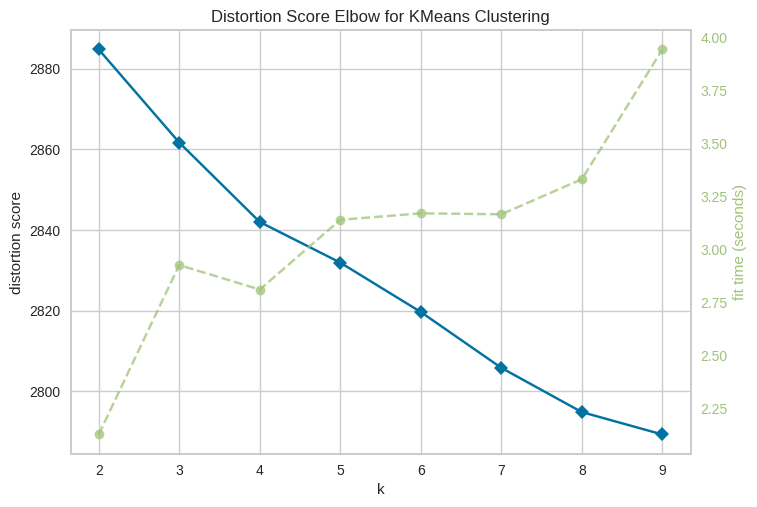

In [61]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252', '#7e9a9a', '#9067a7', '#a1786b', '#6d9a66']

fig, ax = plt.subplots()

#the range of clusters
visualizer = KElbowVisualizer(KMeans(n_init=10), k=(2, 10), ax=ax)

#apply it to the data 
visualizer.fit(d)

# Set X-axis ticks
ax.set_xticks(range(2, 10))

# Show the visualizer
visualizer.show()

plt.show()

In [62]:
clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward').fit(d)

In [67]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(d)

### Bertopic

In [27]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, row):
        ''' Function that takes a row, splits the text into individual words, gets the pos_tag and applies the lemmatizer passing the correct pos. '''
        
        custom_pattern = r'''(?x)          # Set flag to allow verbose regexps
                  |(?:\w+(?:[-]\w+)*) # Words and contractions with hyphens and apostrophes, such as "you're"
                  ''' 
        new_row = []

        # checks the pos_tag for each word 
        for i,j in pos_tag([i for i in regexp_tokenize(row, custom_pattern) if i != '']):
            # if the first letter of the pos_tag is J (adjective), then lemmatize with paramter "a"
            if j[0] == 'J':
                new_row.append(self.wnl.lemmatize(i,pos='a'))
            # if the lowered case first letter of the pos_tag is n (noun) or v (verb), then lemmatize with parameter n or v
            elif j[0].lower() in ['n' ,'v']:
                new_row.append(self.wnl.lemmatize(i,pos=j[0].lower()))
            else:
                new_row.append(self.wnl.lemmatize(i))
                
        return new_row

In [28]:
def create_model(sent_transformer="all-MiniLM-L6-v2", nr_topics="auto", min_cluster_size=15, n_neighbours=15, stop_words=stops, ngram_range=(1,1)):
    """ Recommended steps to create a model from BERTopic docs. """
    
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer(sent_transformer)
    # Step 2 - Reduce dimensionality
    umap_model = UMAP.UMAP(n_neighbors=n_neighbours, n_components=5, min_dist=0.0, metric='cosine')
    # Step 3 - Cluster reduced embeddings
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, tokenizer=LemmaTokenizer())
    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()
    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = PartOfSpeech()

    # All steps together to initialise the model
    topic_model = BERTopic(
    embedding_model=embedding_model,          
    umap_model=umap_model,                    
    hdbscan_model=hdbscan_model,              
    vectorizer_model=vectorizer_model,        
    ctfidf_model=ctfidf_model,                
    representation_model=representation_model,
    nr_topics=nr_topics,
    calculate_probabilities=False
    )

    return topic_model

In [31]:
model = create_model()

In [32]:
def topic_df(model, nr_words=3, word_length=15, sep=" - "):

    # customise the topic labels to be the top n words that represent the model seperated by sep
    labels = model.generate_topic_labels(nr_words=nr_words, topic_prefix=False, word_length=word_length, separator=sep)
    # set the new labels 
    model.set_topic_labels(labels)
    # name the -1 topic "outliers"
    model.set_topic_labels({-1: "outliers"})
    # create topics dataframe, with all the topic information 
    Topics = model.get_topic_info()

    return Topics

In [33]:
def cluster_docs(docs, model=BERTopic(nr_topics="auto")):
    ''' Default model is a simple BERTopic with auto pick number of topics. '''
    
    docs = docs.to_list()   
    doc_topics, probabilities = model.fit_transform(docs)
    Topics = topic_df(model)

    return doc_topics, model, Topics, probabilities

In [41]:
# cluster the Clean Answers with the model we created 
doc_topics, model, Topics, probs = cluster_docs(posts["clean title"], model)

In [43]:
# create a column in our answers dataframe to assign each row the correct topic id 
posts["Topic"] = doc_topics 

# view the new column
posts.head()

,text,datetime,score,subeddit,type,title,clean title,valence,arousal,dominance,...,intero,olf,vis,foot,hand,head,mouth,torso,percent known,Topic
0,,2023-06-08 21:16:59,67098,ChatGPT,submisison,Turned ChatGPT into the ultimate bro,turned chatgpt ultimate bro,0.700935,0.761578,0.495146,...,1.084378,0.441103,2.538847,0.983333,1.333333,2.250000,0.983333,1.183333,0.991667,0
1,,2024-02-19 22:37:20,55734,ChatGPT,submisison,Will smith is wild for this,smith wild,0.747664,0.771870,0.553398,...,1.451357,1.040724,2.738688,0.972136,1.397059,2.400929,1.078173,0.972136,0.914788,2
2,,2023-05-31 07:25:04,51892,ChatGPT,submisison,Photoshop AI Generative Fill was used for its ...,photoshop ai generative fill used intended pur...,0.693925,0.499142,0.737864,...,0.973049,0.248347,2.733702,0.542532,1.907570,2.484972,0.961396,0.608415,0.961874,1
3,The guy typing out these responses for Bing mu...,2023-06-23 03:41:46,51116,ChatGPT,submisison,"Bing ChatGPT too proud to admit mistake, doubl...",bing chatgpt proud admit mistake double rage q...,0.495093,0.646312,0.548786,...,2.156291,0.252056,2.717838,0.792154,1.304330,2.545363,1.942516,0.711605,0.995614,9
4,,2023-04-05 15:39:56,44259,ChatGPT,submisison,Was curious if GPT-4 could recognize text art,curious gpt4 could recognize text art,0.663600,0.460852,0.668841,...,1.485803,0.799920,3.495042,0.305021,1.647477,3.325840,0.997302,0.403108,1.000000,0


In [44]:
# display the topics dataframe
Topics.head(20)

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,776,-1_claude_prompt_use_anthropic,outliers,"[claude, prompt, use, anthropic, claudes, cont...",[free tool convert gpt4 claude 3 opus prompt a...
1,0,594,0_chatgpt_claude_opus_use,chatgpt - claude - opus,"[chatgpt, claude, opus, use, gpt4, gpt, chat, ...","[claude better chatgpt, use chatgpt google, us..."
2,1,577,1_bard_ai_google_image,bard - ai - google,"[bard, ai, google, image, bing, good, answer, ...","[bard v chatgpt google ai really better, bard,..."
3,2,391,2_censorship_filter_sure_bro,censorship - filter - sure,"[censorship, filter, sure, bro, guy, llm, righ...","[well…, well, well got asked]"
4,3,323,3_gemini_pro_ultra_update,gemini - pro - ultra,"[gemini, pro, ultra, update, access, gpt4, v, ...","[gemini 15 gpt4 can’t, got access gemini 15 pr..."
5,4,84,4_account_ban_phone_sign,account - ban - phone,"[account, ban, phone, sign, number, subscripti...","[account banned, account banned, banned account]"
6,5,52,5_limit_message_conversation_simultaneous,limit - message - conversation,"[limit, message, conversation, simultaneous, c...","[anyone know message limit claude 2, got claud..."
7,6,35,6_openai_ceo_employee_breakdown,openai - ceo - employee,"[openai, ceo, employee, breakdown, chaos, boar...",[sam altman openai took major shot elons new g...
8,7,29,7_update_experiment_15pro_date,update - experiment - 15pro,"[update, experiment, 15pro, date, new, experim...","[new update coming, new update coming, update]"
9,8,23,8_prompt_word_generate_tip,prompt - word - generate,"[prompt, word, generate, tip, time, error, hou...","[prompt long, fun challenge enter exact prompt..."


In [161]:
# model.visualize_barchart()

In [160]:
# model.visualize_topics()

In [159]:
# model.visualize_heatmap()

In [158]:
# model.visualize_documents(posts["title"].to_list())

### News Articles 

In [116]:
news_file = pd.read_csv("dataset/archive/data.csv")

In [118]:
news_file.iloc[0]["content"]

'UN Secretary-General Antonio Guterres urged the world Monday to "stop the madness" of climate change as he visited Himalayan regions struggling from rapidly melting glaciers to witness the devastatin… [+2444 chars]'

In [121]:
news = pd.DataFrame(news_file)
news = news[news['full_content'].notna()]
news = news[news['title'].notna()]
news = news[["source_name","title","published_at", "category", "full_content", "url"]]
news["title"] = news["title"].apply(clean_text, args=(True,))
news["full_content"] = news["full_content"].apply(clean_text, args=(True,))

In [122]:
news

,source_name,title,published_at,category,full_content,url
0,International Business Times,un chief urges world stop madness climate change,2023-10-30 10:12:35.000000,Nepal,un secretarygeneral antonio guterres urged wor...,https://www.ibtimes.com/un-chief-urges-world-s...
3,The Indian Express,sikkim warning hydroelectricity push must acco...,2023-10-06 01:20:24.000000,Nepal,least 14 persons lost lives 100 others includi...,https://indianexpress.com/article/opinion/edit...
6,Al Jazeera English,proisrael rallies allowed india palestine soli...,2023-10-25 09:58:17.000000,Nepal,india first nonarab country recognise plo 1970...,https://www.aljazeera.com/news/2023/10/25/pro-...
7,The Indian Express,nation world buying planes india here’s,2023-11-02 05:48:58.000000,Nepal,written alex travelli hari kumar nation world ...,https://indianexpress.com/article/business/avi...
12,The Times of India,pm hasina’s war terror gets daughter india’s vote,2023-11-02 01:12:47.000000,Nepal,new delhi india preferred bangladesh nepal pos...,https://timesofindia.indiatimes.com/india/pm-h...
...,...,...,...,...,...,...
105370,The Indian Express,done wrong party work says karnataka deputy cm...,2023-11-29 10:57:22,Home,karnataka deputy chief minister k shivakumar w...,https://indianexpress.com/article/cities/banga...
105371,Forbes,fc barcelona guarantees 776 million champions ...,2023-11-29 08:41:18,Home,fc barcelona guaranteed least 7676 million cha...,https://www.forbes.com/sites/tomsanderson/2023...
105372,NPR,three hospitals ignored gravely ill fiancé you...,2023-11-29 10:01:12,Home,photo david sarah lubarskys wedding announceme...,https://www.npr.org/2023/11/29/1215016001/heal...
105373,Forbes,kerber’s farm bringing farm table manhattan’s ...,2023-11-29 13:44:33,Home,kerber’s farm bringing farm table manhattan’s ...,https://www.forbes.com/sites/garystern/2023/11...


In [140]:
ai_news = news[news['title'].str.contains(" ai | ml |machine learning|deep learning|artificial intelligence|chatgpt|gpt|gemini|bard|openai|anthropic|dalle|midjourney| llm ")]

In [141]:
ai_news

,source_name,title,published_at,category,full_content,url
290,Phys.Org,nz police using ai catch criminals—but law urg...,2023-10-13 15:33:04.000000,New Zealand,use artificial intelligence ai new zealand pol...,https://phys.org/news/2023-10-nz-police-ai-cri...
929,Deadline,deadline’s strike talk podcast week 23 billy r...,2023-10-06 16:46:25.000000,Panama,hollywood strikes stretched week 23 optimism h...,https://deadline.com/2023/10/actors-strike-sag...
935,BBC News,face search company clearview ai overturns uk ...,2023-10-18 09:45:15.000000,Panama,company enables clients search database billio...,https://www.bbc.co.uk/news/technology-67133157
952,Forbes,uk privacy watchdog cant sanction clearview ai...,2023-10-19 10:13:26.000000,Panama,authentication facial recognition uks privacy ...,https://www.forbes.com/sites/emmawoollacott/20...
1711,Wired,slovakia’s election deepfakes show ai danger d...,2023-10-03 11:00:00.000000,Poland,two daysbefore slovakia’s elections audio reco...,https://www.wired.com/story/slovakias-election...
...,...,...,...,...,...,...
104744,Forbes,15 common mistakes avoid using generative ai s...,2023-11-29 13:15:00,Relationships,businesses increasingly integrate generative a...,https://www.forbes.com/sites/forbescommunicati...
104797,The Times of India,elon musk shares poem written ai chatbot grok ...,2023-11-29 12:07:32,Artificial Intelligence,agencies elon musk file pic worlds richest per...,https://economictimes.indiatimes.com/news/new-...
104807,GlobeNewswire,medbright ai unveils new investment presentati...,2023-11-29 13:00:00,Artificial Intelligence,vancouver british columbia nov 29 2023 globe n...,https://www.globenewswire.com/news-release/202...
104812,The Times of India,quote unquote charlie munger berkshire vc inve...,2023-11-29 10:27:48,Artificial Intelligence,ap charlie munger vicechairman berkshire hatha...,https://economictimes.indiatimes.com/magazines...


In [156]:
sustainable_ai = ai_news[ai_news['full_content'].str.contains("sustain|climate|environment|carbon|emissions|footprint|environmental degradation|energy")]

In [157]:
sustainable_ai

,source_name,title,published_at,category,full_content,url
1730,Business Insider,ultrarich obsessed doomsday bunkers — sam altm...,2023-10-20 05:20:26.000000,Poland,doomsday predictions likenuclear war climate c...,https://www.businessinsider.com/billionaire-bu...
2845,Forbes,biden’s bold ai blueprint navigating ethics in...,2023-11-02 12:43:03.000000,Cars,us vice president kamala harris delivers speec...,https://www.forbes.com/sites/markminevich/2023...
3051,The Times of India,sap india leans ai tools midmarket startups focus,2023-11-02 00:30:00.000000,Cars,ettech kulmeet bawa president managing directo...,https://economictimes.indiatimes.com/tech/info...
4833,The Indian Express,uk’s ai safety summit 6 key takeaways future a...,2023-11-02 12:54:42.000000,Climate,uk hosted major artificial intelligence ai sum...,https://indianexpress.com/article/technology/a...
4933,ABC News,harris sunak due discuss cuttingedge ai risks ...,2023-11-02 10:30:46.000000,Climate,bletchley park england british prime minister ...,https://abcnews.go.com/Technology/wireStory/ha...
...,...,...,...,...,...,...
104412,The Times of India,openai unlikely offer board seat microsoft inv...,2023-11-29 01:39:30,Science,ap chatgpt owner openai expected offer microso...,https://economictimes.indiatimes.com/tech/tech...
104424,The Times of India,big tech charge chatgpt turns one,2023-11-29 05:44:50,Science,reuters year historymaking release chatgpt ai ...,https://economictimes.indiatimes.com/tech/tech...
104606,Forbes,5 chatgpt prompts master topic apply business,2023-11-29 13:00:00,Politics,5 chatgpt prompts master topic apply business ...,https://www.forbes.com/sites/jodiecook/2023/11...
104797,The Times of India,elon musk shares poem written ai chatbot grok ...,2023-11-29 12:07:32,Artificial Intelligence,agencies elon musk file pic worlds richest per...,https://economictimes.indiatimes.com/news/new-...
